In [183]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from gplearn.genetic import SymbolicRegressor, SymbolicTransformer
import matplotlib.pyplot as plt

In [184]:
df = pd.read_csv("car_sales_data.csv")

In [185]:
print("First five rows: \n")
df.head()

First five rows: 



,Manufacturer,Model,Engine size,Fuel type,Year of manufacture,Mileage,Price
0,Ford,Fiesta,1.0,Petrol,2002,127300,3074
1,Porsche,718 Cayman,4.0,Petrol,2016,57850,49704
2,Ford,Mondeo,1.6,Diesel,2014,39190,24072
3,Toyota,RAV4,1.8,Hybrid,1988,210814,1705
4,VW,Polo,1.0,Petrol,2006,127869,4101


In [186]:
print("Data informations: \n")
df.info()

Data informations: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Manufacturer         50000 non-null  object 
 1   Model                50000 non-null  object 
 2   Engine size          50000 non-null  float64
 3   Fuel type            50000 non-null  object 
 4   Year of manufacture  50000 non-null  int64  
 5   Mileage              50000 non-null  int64  
 6   Price                50000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 2.7+ MB


In [187]:
print("Data descriptions: \n")
df.describe()

Data descriptions: 



,Engine size,Year of manufacture,Mileage,Price
count,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.773058,2004.209440,112497.320700,13828.903160
std,0.734108,9.645965,71632.515602,16416.681336
min,1.000000,1984.000000,630.000000,76.000000
25%,1.400000,1996.000000,54352.250000,3060.750000
50%,1.600000,2004.000000,100987.500000,7971.500000
75%,2.000000,2012.000000,158601.000000,19026.500000
max,5.000000,2022.000000,453537.000000,168081.000000


In [188]:
df_encoded = pd.get_dummies(df, columns=["Fuel type", "Manufacturer", "Model"], drop_first=True)

X = df_encoded.drop(columns=["Price"])
y = df_encoded["Price"]

X[["Year of manufacture"]] = 2025 - X[["Year of manufacture"]]
X = X.rename(columns={'Year of manufacture': 'Age of car'})

X[["Engine size", "Mileage", "Age of car"]] = (
            (X[["Engine size", "Mileage", "Age of car"]] - X[["Engine size", "Mileage", "Age of car"]].mean()) /
            X[["Engine size", "Mileage", "Age of car"]].std())
y = (y - y.mean()) / y.std()

In [224]:
function_set = ['add', 'sub', 'mul', 'div',
                'sqrt', 'log', 'abs', 'neg', 'inv',
                'max', 'min']
transformer = SymbolicTransformer(generations=20,
                                  population_size=2000,
                                  hall_of_fame=100,
                                  n_components=10,
                                  function_set=function_set,
                                  parsimony_coefficient=0.0005,
                                  max_samples=0.9,
                                  verbose=1,
                                  random_state=0,
                                  n_jobs=3)

transformer.fit(X, y)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.04         0.370666        3          0.97938         0.979017     47.89s
   1     4.09         0.847473        6         0.979896         0.978174     38.31s
   2     1.91         0.967146        5         0.979772         0.978539     29.88s
   3     2.87         0.973602        3         0.979735         0.975343     36.29s
   4     3.04         0.974954        3         0.979746         0.975481     34.86s
   5     3.04         0.975142        3         0.979805         0.975215     25.83s
   6     3.03         0.975897        3         0.979741         0.975292     27.86s
   7     3.03         0.973951        3         0.979766         0.975302     21.86s
   8     3.01         0.972839        3         0.979727         0.975628  

SymbolicTransformer(function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                                  'abs', 'neg', 'inv', 'max', 'min'],
                    max_samples=0.9, n_jobs=3, parsimony_coefficient=0.0005,
                    population_size=2000, random_state=0, verbose=1)

In [226]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,-1.053058,0.229053,0.206647,False,True,True,False,False,False,False,...,-1.229053,-1.229053,-1.229053,1.229053,-1.229053,-1.229053,1.229053,-1.229053,-1.229053,-1.229053
1,3.033535,-1.222331,-0.762884,False,True,False,True,False,False,False,...,20.03664,20.03664,20.03664,-20.03664,20.03664,20.03664,-20.03664,20.03664,20.03664,20.03664
2,-0.235739,-1.01499,-1.023381,False,False,True,False,False,False,False,...,5.434916,5.434916,5.434916,-5.434916,5.434916,5.434916,-5.434916,5.434916,5.434916,5.434916
3,0.0367,1.680437,1.372515,True,False,False,False,True,False,False,...,-0.680437,-0.680437,-0.680437,0.680437,-0.680437,-0.680437,0.680437,-0.680437,-0.680437,-0.680437
4,-1.053058,-0.185628,0.214591,False,True,False,False,False,True,False,...,-0.814372,-0.814372,-0.814372,0.814372,-0.814372,-0.814372,0.814372,-0.814372,-0.814372,-0.814372


In [227]:
y.head()

0   -0.655120
1    2.185283
2    0.623944
3   -0.738511
4   -0.592562
Name: Price, dtype: float64

In [228]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [229]:
est_gp = SymbolicRegressor(
    population_size=5000,
    generations=30,
    p_crossover=0.7,
    p_subtree_mutation=0.1,
    p_hoist_mutation=0.1,
    p_point_mutation=0.1,
    max_samples=0.9,
    verbose=1,
    tournament_size=20,
    parsimony_coefficient=0.001,
    stopping_criteria=0.01,
    metric='mse',
    n_jobs=-1,
    random_state=42
)

est_gp.fit(X_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    25.58      2.91628e+22        3         0.233809          0.23699      1.75m
   1     6.46        1.277e+18        3         0.233695         0.238015      2.90m
   2     3.64          10352.2        3         0.232928         0.244915      1.19m
   3     3.16      1.66053e+06        5         0.170715         0.163032      1.15m
   4     3.23      3.14975e+06        5         0.169656         0.172565      1.07m
   5     3.24           824860        5         0.168988         0.178582      1.02m
   6     3.78        4.671e+06        7         0.159879         0.165001     59.67s
   7     4.97       3.7374e+07        7         0.104816          0.10849      1.02m
   8     5.81          11470.4       11        0.0976632         0.100828  

SymbolicRegressor(generations=30, max_samples=0.9, metric='mse', n_jobs=-1,
                  p_crossover=0.7, p_hoist_mutation=0.1, p_point_mutation=0.1,
                  p_subtree_mutation=0.1, population_size=5000, random_state=42,
                  stopping_criteria=0.01, verbose=1)

In [230]:
y_pred_train = pd.Series(est_gp.predict(X_train), index=X_train.index)
y_pred_train.head()

18306   -0.549882
49528   -0.379314
44745    0.546379
46827    0.827866
27531    0.978208
dtype: float64

In [231]:
y_train.head()

18306   -0.628136
49528   -0.457334
44745    0.530625
46827    0.677183
27531    0.580818
Name: Price, dtype: float64

In [232]:
y_pred_test = pd.Series(est_gp.predict(X_test), index=X_test.index)
y_pred_test.head()

33553    2.863597
9427     1.363031
199      0.281835
12447   -0.603084
39489   -0.419705
dtype: float64

In [233]:
y_test.head()

33553    3.336125
9427     1.306421
199      0.215701
12447   -0.646653
39489   -0.548034
Name: Price, dtype: float64

In [235]:
print("R2 Score of Train Samples: %", est_gp.score(X_train, y_train) * 100)
print("R2 Score of Test Samples: %", est_gp.score(X_test, y_test) * 100)

R2 Score of Train Samples: % 95.7298188967886
R2 Score of Test Samples: % 95.56235298300429


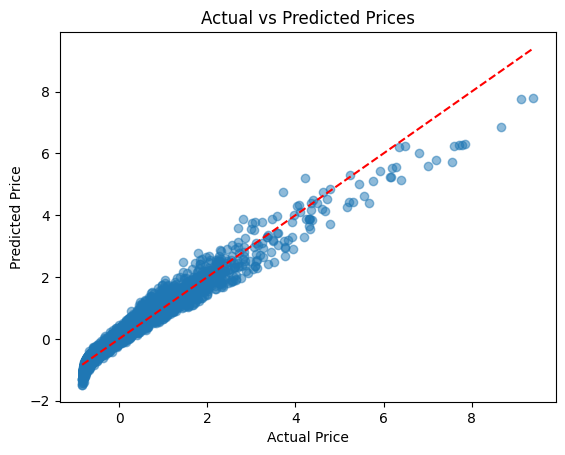

In [236]:
# Toplam örnek sayısı
n = len(y_train)

# Rastgele 1000 indeks seç (tekrarsız)
idx = np.random.choice(n, size=5000, replace=False)

# Alt küme oluştur
y_train_sample = y_train.iloc[idx] if hasattr(y_train, "iloc") else y_train[idx]
y_pred_sample = y_pred_train.iloc[idx] if hasattr(y_pred_train, "iloc") else y_pred_train[idx]

# Scatter plot
plt.scatter(y_train_sample, y_pred_sample, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.show()

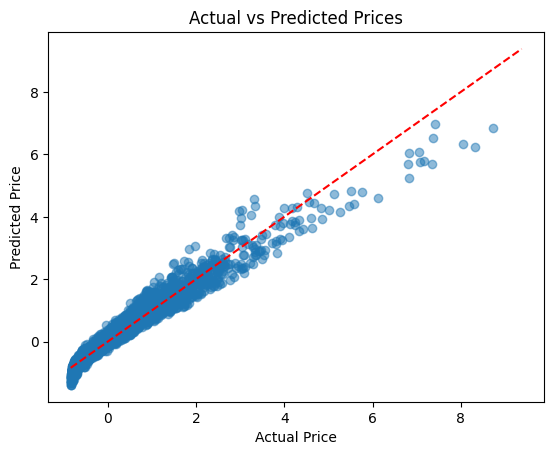

In [237]:
# Toplam örnek sayısı
n = len(y_test)

# Rastgele 1000 indeks seç (tekrarsız)
idx = np.random.choice(n, size=5000, replace=False)

# Alt küme oluştur
y_test_sample = y_test.iloc[idx] if hasattr(y_test, "iloc") else y_test[idx]
y_pred_sample = y_pred_test.iloc[idx] if hasattr(y_pred_test, "iloc") else y_pred_test[idx]

# Scatter plot
plt.scatter(y_test_sample, y_pred_sample, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.show()